In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

## Data preprocessing

In [2]:
df = pd.read_csv('./train.csv')
df = df.drop('Id', 1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
enc_features = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
               'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual',
               'OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual',
               'ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
               'Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
               'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature',
               'SaleType','SaleCondition']
for enc in enc_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,...,0,0,0,1,0,0,0,0,1,0


In [4]:
real_features = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtUnfSF',
                'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
                'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars',
                'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
                'MiscVal','MoSold','YrSold']
cat_features = list(set(df.columns.values.tolist()) - set(real_features))
cat_features.remove('SalePrice')
print (real_features)
print (cat_features)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['GarageType_Attchd', 'BsmtFinType2_BLQ', 'ExterQual_Gd', 'SaleType_Oth', 'RoofStyle_Hip', 'Condition2_Artery', 'MSSubClass_60', 'OverallCond_8', 'Exterior2nd_Wd Sdng', 'GarageCond_Fa', 'Condition2_RRAn', 'Exterior1st_VinylSd', 'Neighborhood_Somerst', 'GarageCond_TA', 'BsmtExposure_Mn', 'Electrical_FuseP', 'Exterior2nd_BrkFace', 'Electrical_SBrkr', 'Condition1_RRNe', 'KitchenQual_Gd', 'Neighborhood_Edwards', 'Condition1_Feedr', 'HeatingQC_Ex', 'Heating_Floor', 'Foundation_BrkTil', 'GarageType_BuiltIn', 'Condition1_PosA', 'MSSubClass_85', 'Foundation_C

In [5]:
df[real_features].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,1971.267808,1984.865753,103.685262,443.639726,567.240411,1057.429452,1162.626712,346.992466,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,24.284752,9981.264932,30.202904,20.645407,181.066207,456.098091,441.866955,438.705324,386.587738,436.528436,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,59.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,477.500000,991.500000,1087.000000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,80.000000,11601.500000,2000.000000,2004.000000,166.000000,712.250000,808.000000,1298.250000,1391.250000,728.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,2336.000000,6110.000000,4692.000000,2065.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [6]:
df[cat_features].describe()

,GarageType_Attchd,BsmtFinType2_BLQ,ExterQual_Gd,SaleType_Oth,RoofStyle_Hip,Condition2_Artery,MSSubClass_60,OverallCond_8,Exterior2nd_Wd Sdng,GarageCond_Fa,...,Exterior2nd_AsbShng,BsmtQual_Gd,RoofMatl_Metal,PoolQC_Fa,Condition1_RRAe,Exterior1st_Stucco,CentralAir_Y,OverallQual_1,Neighborhood_StoneBr,Exterior1st_CemntBd
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.595890,0.022603,0.334247,0.002055,0.195890,0.001370,0.204795,0.049315,0.134932,0.023973,...,0.013699,0.423288,0.000685,0.001370,0.007534,0.017123,0.934932,0.001370,0.017123,0.041781
std,0.490887,0.148684,0.471888,0.045299,0.397021,0.036999,0.403690,0.216599,0.341767,0.153016,...,0.116277,0.494249,0.026171,0.036999,0.086502,0.129775,0.246731,0.036999,0.129775,0.200157
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
print (df.shape)

(1460, 320)


In [8]:
for ft in real_features:
    df[ft] = df[ft].fillna(0)
for ft in cat_features:
    df[ft] = df[ft].fillna(0)    

In [9]:
print (df.shape)

(1460, 320)


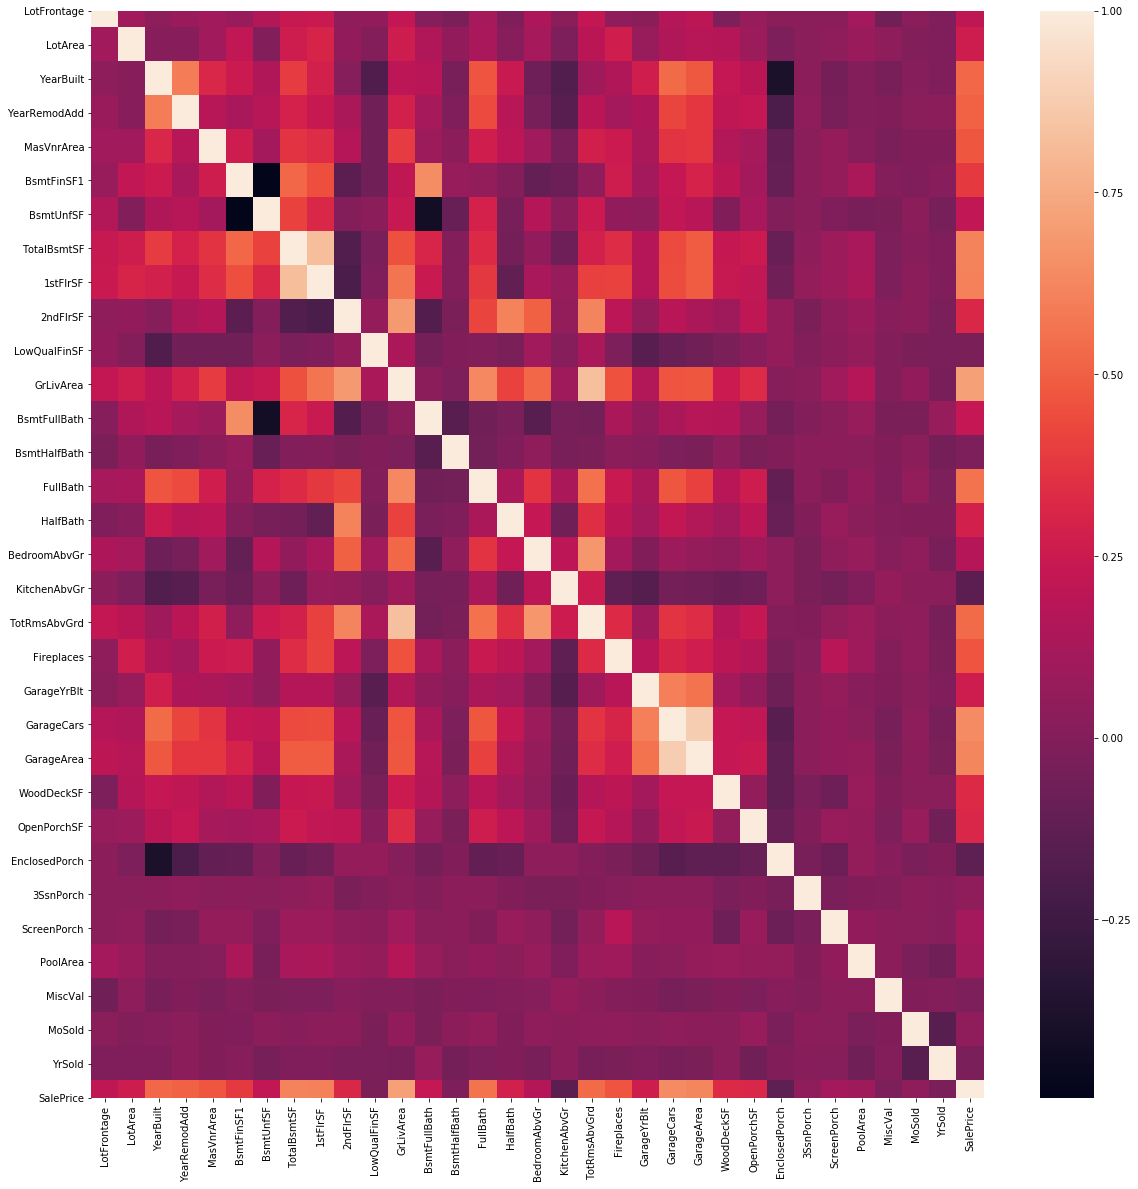

In [10]:
plt.figure(figsize=(20, 20))
sns.heatmap(df[real_features + ['SalePrice']].corr())

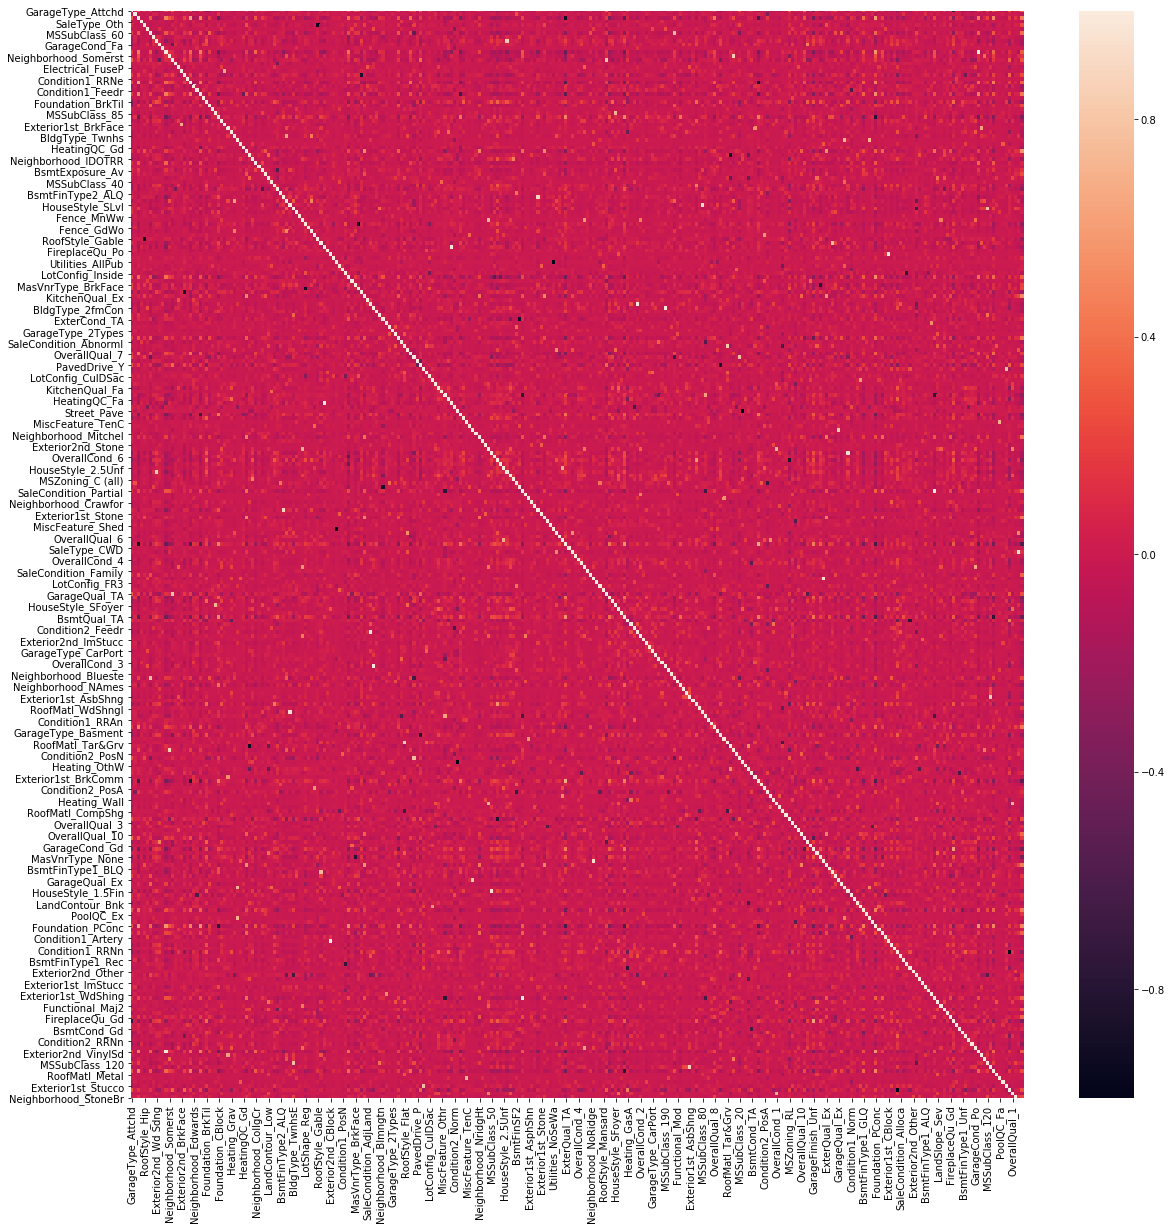

In [11]:
plt.figure(figsize=(20, 20))
sns.heatmap(df[cat_features + ['SalePrice']].corr())

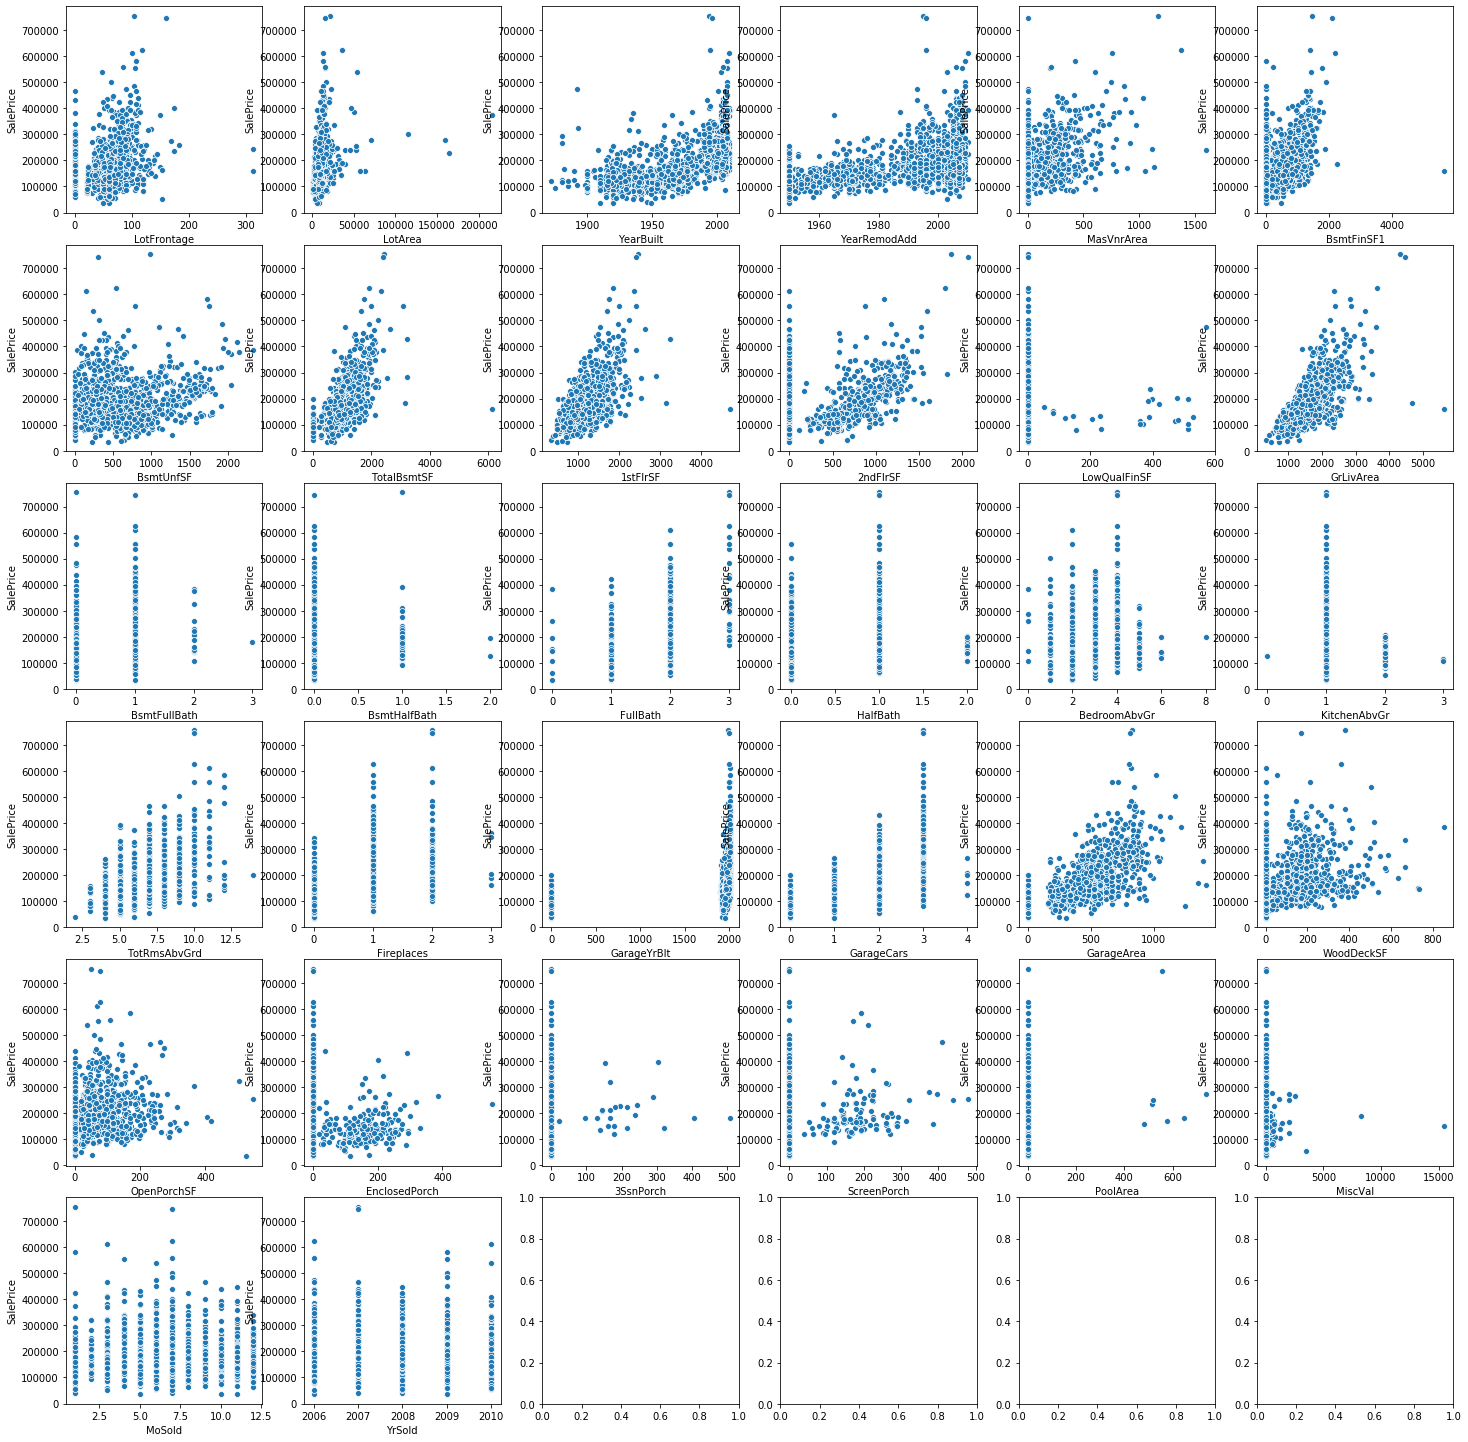

In [12]:
fig, ax = plt.subplots(6, 6, figsize=(20, 20))
fig.tight_layout()
ax = iter(ax.flatten())
for feat in real_features:
    sns.scatterplot(x=feat, y='SalePrice', data=df, ax=next(ax))

In [13]:
y = df['SalePrice'].to_numpy()
df = df.drop('SalePrice', 1)

X_real = df[real_features].to_numpy()
X_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_real[0]))
print ("X_cat: {} ".format(X_cat[0]))
print ("y: {} ".format(y[0]))

X_real: [6.500e+01 8.450e+03 2.003e+03 2.003e+03 1.960e+02 7.060e+02 1.500e+02
 8.560e+02 8.560e+02 8.540e+02 0.000e+00 1.710e+03 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 3.000e+00 1.000e+00 8.000e+00 0.000e+00 2.003e+03
 2.000e+00 5.480e+02 0.000e+00 6.100e+01 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.000e+00 2.008e+03] 
X_cat: [1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0] 
y: 208500 


### Polynomial features

In [13]:
#transform = PolynomialFeatures(2)
#X_poly_real = transform.fit_transform(X_real)
X_poly_real = X_real

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_poly_real)

In [15]:
print (X_real_scaled.shape)
print (X_cat.shape)
print (y.shape)

(1460, 32)
(1460, 287)
(1460,)


### Checking dataset

In [16]:
X = np.hstack((X_real_scaled, X_cat))

In [17]:
xi = np.isfinite(X) 
print (xi[np.where(xi == False)].sum())

xn = np.isnan(X) 
print (xn[np.where(xn == False)].sum())

0
0


In [18]:
yi = np.isfinite(y) 
print (yi[np.where(yi == False)].sum())

yn = np.isnan(y) 
print (yn[np.where(yn == False)].sum())

0
0


## Features selection with Lasso

In [19]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_val_score

In [20]:
param_grid = {
    'alpha': [60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0], 'max_iter': [100000]
}
estimator = Lasso()

ls_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
ls_model.fit(X, y)


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] alpha=60.0, max_iter=100000 .....................................
[CV]  alpha=60.0, max_iter=100000, score=0.9141121982761965, total=   0.5s
[CV] alpha=60.0, max_iter=100000 .....................................
[CV] alpha=60.0, max_iter=100000 .....................................
[CV] alpha=60.0, max_iter=100000 .....................................
[CV] alpha=60.0, max_iter=100000 .....................................
[CV]  alpha=60.0, max_iter=100000, score=0.9088341713809143, total=   2.7s
[CV]  alpha=60.0, max_iter=100000, score=0.9101606577109598, total=   2.6s
[CV]  alpha=60.0, max_iter=100000, score=0.9317674219835181, total=   2.8s
[CV]  alpha=60.0, max_iter=100000, score=0.7373869957880318, total=   2.8s
[CV] alpha=60.0, max_iter=100000 .....................................
[CV] alpha=60.0, max_iter=100000 .....................................
[CV] alpha=60.0, max_iter=100000 ................................

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.6s


[CV] alpha=80.0, max_iter=100000 .....................................
[CV] alpha=80.0, max_iter=100000 .....................................
[CV] alpha=80.0, max_iter=100000 .....................................
[CV] alpha=80.0, max_iter=100000 .....................................
[CV]  alpha=80.0, max_iter=100000, score=0.5884344814706983, total=   1.3s
[CV] alpha=80.0, max_iter=100000 .....................................
[CV]  alpha=80.0, max_iter=100000, score=0.906426442814857, total=   2.4s
[CV] alpha=90.0, max_iter=100000 .....................................
[CV]  alpha=80.0, max_iter=100000, score=0.819074722742434, total=   2.7s
[CV]  alpha=80.0, max_iter=100000, score=0.9129034367182125, total=   2.6s
[CV] alpha=90.0, max_iter=100000 .....................................
[CV] alpha=90.0, max_iter=100000 .....................................
[CV]  alpha=80.0, max_iter=100000, score=0.8989309907882098, total=   2.1s
[CV]  alpha=90.0, max_iter=100000, score=0.9155161072836969

[CV]  alpha=140.0, max_iter=100000, score=0.9134058661209224, total=   0.7s
[CV] alpha=140.0, max_iter=100000 ....................................
[CV]  alpha=130.0, max_iter=100000, score=0.8997318360083634, total=   0.8s
[CV] alpha=140.0, max_iter=100000 ....................................
[CV]  alpha=140.0, max_iter=100000, score=0.9214705702497713, total=   0.8s
[CV] alpha=140.0, max_iter=100000 ....................................
[CV]  alpha=140.0, max_iter=100000, score=0.9317982229906837, total=   0.7s
[CV] alpha=140.0, max_iter=100000 ....................................
[CV]  alpha=140.0, max_iter=100000, score=0.8960963542861113, total=   0.7s
[CV] alpha=140.0, max_iter=100000 ....................................
[CV]  alpha=140.0, max_iter=100000, score=0.7529117750427972, total=   0.8s
[CV] alpha=140.0, max_iter=100000 ....................................
[CV]  alpha=140.0, max_iter=100000, score=0.9043595782695112, total=   0.8s
[CV] alpha=140.0, max_iter=100000 ........

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0], 'max_iter': [100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [21]:
print (ls_model.best_estimator_)

Lasso(alpha=150.0, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


In [22]:
print (ls_model.best_score_)

0.8585783787835182


In [23]:
c = 0
not_null_idx = []
for cf in ls_model.best_estimator_.coef_:
    if cf != 0:
        not_null_idx.append(c)
    c += 1
print (len(not_null_idx))    
print (not_null_idx)    

91
[1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 34, 42, 45, 47, 57, 58, 63, 79, 84, 93, 100, 101, 103, 104, 105, 112, 117, 120, 131, 135, 137, 139, 145, 150, 151, 157, 160, 168, 170, 172, 175, 176, 180, 182, 185, 187, 190, 191, 195, 197, 202, 207, 209, 216, 219, 223, 228, 229, 232, 238, 241, 248, 258, 259, 267, 274, 277, 289, 291, 300, 306, 314, 315]


In [24]:
X = X[:, not_null_idx]
print (X.shape)

(1460, 91)


### SVR

In [25]:
from sklearn.svm import SVR

In [26]:
svr_model = SVR(kernel='linear', C=50.0, epsilon=1.0)

score = cross_val_score(svr_model, X, y, cv=10)
score_mean = score.mean()

In [27]:
print (score_mean)

0.7727633739854766


In [28]:
param_grid = {
    'kernel': ['linear'],
    'degree': [1],
    'C': [600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0],
    'epsilon': [0.01, 0.05, 0.1, 0.12]
}
estimator = SVR()

svr2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
svr2_model.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] C=600.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV] C=600.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV] C=600.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV] C=600.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV]  C=600.0, degree=1, epsilon=0.01, kernel=linear, score=0.912604556701548, total=  14.3s
[CV] C=600.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV]  C=600.0, degree=1, epsilon=0.01, kernel=linear, score=0.926628804205716, total=  15.4s
[CV] C=600.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV]  C=600.0, degree=1, epsilon=0.01, kernel=linear, score=0.8874462308530845, total=  24.5s
[CV] C=600.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV]  C=600.0, degree=1, epsilon=0.01, kernel=linear, score=0.7751726161115162, total=  25.6s
[CV] C=600.0, degree=1, epsilon=0.01, kernel=linear ..............

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  3.0min


[CV]  C=600.0, degree=1, epsilon=0.1, kernel=linear, score=0.8930644385939069, total=  12.0s
[CV] C=600.0, degree=1, epsilon=0.1, kernel=linear ...................
[CV]  C=600.0, degree=1, epsilon=0.05, kernel=linear, score=0.908882078173245, total= 1.2min
[CV] C=600.0, degree=1, epsilon=0.1, kernel=linear ...................
[CV]  C=600.0, degree=1, epsilon=0.1, kernel=linear, score=0.5853566022554897, total=  18.7s
[CV] C=600.0, degree=1, epsilon=0.12, kernel=linear ..................
[CV]  C=600.0, degree=1, epsilon=0.1, kernel=linear, score=0.9007366050906561, total=  30.6s
[CV] C=600.0, degree=1, epsilon=0.12, kernel=linear ..................
[CV]  C=600.0, degree=1, epsilon=0.12, kernel=linear, score=0.9126046762453943, total=  13.5s
[CV] C=600.0, degree=1, epsilon=0.12, kernel=linear ..................
[CV]  C=600.0, degree=1, epsilon=0.12, kernel=linear, score=0.887446027058354, total=  15.9s
[CV] C=600.0, degree=1, epsilon=0.12, kernel=linear ..................
[CV]  C=600.0, 

[CV]  C=650.0, degree=1, epsilon=0.12, kernel=linear, score=0.8938258640750767, total=  16.7s
[CV] C=650.0, degree=1, epsilon=0.12, kernel=linear ..................
[CV]  C=650.0, degree=1, epsilon=0.12, kernel=linear, score=0.8720745010645341, total=  26.1s
[CV] C=650.0, degree=1, epsilon=0.12, kernel=linear ..................
[CV]  C=650.0, degree=1, epsilon=0.12, kernel=linear, score=0.5884804553970946, total=  19.6s
[CV] C=700.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV]  C=650.0, degree=1, epsilon=0.12, kernel=linear, score=0.9016769034518726, total=  32.7s
[CV] C=700.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV]  C=650.0, degree=1, epsilon=0.12, kernel=linear, score=0.9009777856492415, total=  36.1s
[CV] C=700.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV]  C=700.0, degree=1, epsilon=0.01, kernel=linear, score=0.9136839002963185, total=  18.1s
[CV] C=700.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV]  C=65

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 14.3min


[CV]  C=750.0, degree=1, epsilon=0.01, kernel=linear, score=0.9145281504484317, total=  20.1s
[CV] C=750.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV]  C=750.0, degree=1, epsilon=0.01, kernel=linear, score=0.9272833014661673, total=  15.2s
[CV] C=750.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV]  C=750.0, degree=1, epsilon=0.01, kernel=linear, score=0.8908890530962187, total=  31.1s
[CV] C=750.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV]  C=750.0, degree=1, epsilon=0.01, kernel=linear, score=0.7753365467034568, total=  52.0s
[CV] C=750.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV]  C=750.0, degree=1, epsilon=0.01, kernel=linear, score=0.8967703423663484, total=  41.1s
[CV] C=750.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV]  C=750.0, degree=1, epsilon=0.01, kernel=linear, score=0.9053317472415305, total=  35.8s
[CV] C=750.0, degree=1, epsilon=0.01, kernel=linear ..................
[CV]  C=75

[CV]  C=800.0, degree=1, epsilon=0.05, kernel=linear, score=0.9151267917945003, total=  29.1s
[CV] C=800.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=800.0, degree=1, epsilon=0.05, kernel=linear, score=0.9282634975362107, total=  18.6s
[CV] C=800.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=800.0, degree=1, epsilon=0.05, kernel=linear, score=0.8916067290050773, total=  43.3s
[CV] C=800.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=800.0, degree=1, epsilon=0.05, kernel=linear, score=0.8977598971855683, total=  28.2s
[CV] C=800.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=800.0, degree=1, epsilon=0.05, kernel=linear, score=0.8775867435142444, total=  57.6s
[CV] C=800.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=800.0, degree=1, epsilon=0.05, kernel=linear, score=0.9047651973185176, total=  38.2s
[CV] C=800.0, degree=1, epsilon=0.05, kernel=linear ..................
[CV]  C=80

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 27.5min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': ['linear'], 'degree': [1], 'C': [600.0, 650.0, 700.0, 750.0, 800.0], 'epsilon': [0.01, 0.05, 0.1, 0.12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [29]:
print (svr2_model.best_estimator_)

SVR(C=800.0, cache_size=200, coef0=0.0, degree=1, epsilon=0.12, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [30]:
print (svr2_model.best_score_)

0.8599762579978982


## Linear regression

### Ridge

In [31]:
rg_model = Ridge(alpha=.5)

score = cross_val_score(rg_model, X, y, cv=10)
score_mean = score.mean()

In [32]:
print (score_mean)

0.8689882029711276


In [33]:
score = cross_val_score(rg_model, X, y, cv=5)
score_mean = score.mean()

In [34]:
print (score_mean)

0.8653739305996593


In [35]:
param_grid = {
    'alpha': [1., 1.2, 1.4, 1.6, 1.8, 2.0],
    'solver': ['auto', 'svd', 'cholesky']
}
estimator = Ridge()

rg2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
rg2_model.fit(X, y)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV] alpha=1.0, solver=auto ..........................................
[CV] alpha=1.0, solver=auto ..........................................
[CV] . alpha=1.0, solver=auto, score=0.9175777028002134, total=   0.0s
[CV] alpha=1.0, solver=auto ..........................................
[CV] alpha=1.0, solver=auto ..........................................
[CV] . alpha=1.0, solver=auto, score=0.9343592292027252, total=   0.0s
[CV] alpha=1.0, solver=auto ..........................................
[CV] . alpha=1.0, solver=auto, score=0.9195233498982197, total=   0.0s
[CV] alpha=1.0, solver=auto ..........................................
[CV] . alpha=1.0, solver=auto, score=0.8009755249768038, total=   0.0s
[CV] . alpha=1.0, solver=auto, score=0.9129401908630674, total=   0.0s
[CV] alpha=1.0, solver=auto ..........................................
[CV] alpha=1.0, solver=auto ..........................................
[CV] .. alpha=

[CV] . alpha=1.4, solver=auto, score=0.9099677208293389, total=   0.0s
[CV] alpha=1.4, solver=auto ..........................................
[CV]  alpha=1.2, solver=cholesky, score=0.909797466317297, total=   0.0s
[CV] . alpha=1.4, solver=auto, score=0.8906771931896457, total=   0.0s
[CV] alpha=1.2, solver=cholesky ......................................
[CV] alpha=1.4, solver=auto ..........................................
[CV]  alpha=1.2, solver=cholesky, score=0.6308862275482935, total=   0.0s
[CV] alpha=1.2, solver=cholesky ......................................
[CV]  alpha=1.2, solver=cholesky, score=0.8962593991354204, total=   0.0s
[CV] . alpha=1.4, solver=auto, score=0.8990431718956219, total=   0.0s
[CV] alpha=1.4, solver=auto ..........................................
[CV] alpha=1.4, solver=cholesky ......................................
[CV] ... alpha=1.4, solver=svd, score=0.933300163400307, total=   0.1s
[CV] alpha=1.4, solver=svd ..........................................

[CV] .. alpha=1.8, solver=auto, score=0.802199224625505, total=   0.0s
[CV] alpha=1.8, solver=auto ..........................................
[CV] ... alpha=1.4, solver=svd, score=0.909309747084089, total=   0.2s
[CV] alpha=1.4, solver=svd ...........................................
[CV] .. alpha=1.6, solver=svd, score=0.8020319198981916, total=   0.1s
[CV] alpha=1.6, solver=svd ...........................................
[CV] alpha=1.8, solver=svd ...........................................
[CV] . alpha=1.8, solver=auto, score=0.9076594813811233, total=   0.0s
[CV] alpha=1.8, solver=auto ..........................................
[CV] . alpha=1.8, solver=auto, score=0.8954541568628483, total=   0.0s
[CV] alpha=1.8, solver=auto ..........................................
[CV] .. alpha=1.4, solver=svd, score=0.6317453902643646, total=   0.1s
[CV] .. alpha=1.6, solver=svd, score=0.9087484375760968, total=   0.0s
[CV] alpha=1.4, solver=svd ...........................................
[CV] .

[CV] alpha=2.0, solver=svd ...........................................
[CV] alpha=1.8, solver=svd ...........................................
[CV] .. alpha=1.8, solver=svd, score=0.6327989829854793, total=   0.0s
[CV] alpha=1.8, solver=svd ...........................................
[CV] .. alpha=2.0, solver=svd, score=0.9066766371319659, total=   0.0s
[CV] alpha=2.0, solver=svd ...........................................
[CV] .. alpha=1.8, solver=svd, score=0.8959388592913492, total=   0.0s
[CV] .. alpha=2.0, solver=svd, score=0.8970946962743173, total=   0.0s
[CV] alpha=2.0, solver=svd ...........................................
[CV] .. alpha=2.0, solver=svd, score=0.8980063593191252, total=   0.0s
[CV] alpha=2.0, solver=svd ...........................................
[CV] .. alpha=2.0, solver=svd, score=0.9083493195922878, total=   0.0s
[CV] alpha=2.0, solver=svd ...........................................
[CV] .. alpha=2.0, solver=svd, score=0.6330847278239687, total=   0.0s
[CV] a

[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    2.2s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'solver': ['auto', 'svd', 'cholesky']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [36]:
print (rg2_model.best_estimator_)

Ridge(alpha=1.4, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='svd', tol=0.001)


In [37]:
print (rg2_model.best_score_)

0.8705699439353547


### ElasticNet

In [38]:
el_model = ElasticNet(alpha=.5, l1_ratio=.5, max_iter=100000)

score = cross_val_score(el_model, X, y, cv=10)
score_mean = score.mean()

In [39]:
print (score_mean)

0.821379335460161


In [40]:
score = cross_val_score(el_model, X, y, cv=5)
score_mean = score.mean()

In [41]:
print (score_mean)

0.8117811561016559


In [42]:
param_grid = {'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],               
              'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_iter': [100000]}
estimator = ElasticNet()

el2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
el2_model.fit(X, y)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] alpha=0.0001, l1_ratio=0.1, max_iter=100000 .....................
[CV] alpha=0.0001, l1_ratio=0.1, max_iter=100000 .....................
[CV] alpha=0.0001, l1_ratio=0.1, max_iter=100000 .....................
[CV] alpha=0.0001, l1_ratio=0.1, max_iter=100000 .....................
[CV]  alpha=0.0001, l1_ratio=0.1, max_iter=100000, score=0.9160437576303953, total=   0.2s
[CV]  alpha=0.0001, l1_ratio=0.1, max_iter=100000, score=0.9329239910338141, total=   0.1s
[CV] alpha=0.0001, l1_ratio=0.1, max_iter=100000 .....................
[CV] alpha=0.0001, l1_ratio=0.1, max_iter=100000 .....................
[CV]  alpha=0.0001, l1_ratio=0.1, max_iter=100000, score=0.9337830420185761, total=   0.2s
[CV]  alpha=0.0001, l1_ratio=0.1, max_iter=100000, score=0.7949966059650848, total=   0.2s
[CV] alpha=0.0001, l1_ratio=0.1, max_iter=100000 .....................
[CV] alpha=0.0001, l1_ratio=0.1, max_iter=100000 .....................
[CV] 

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.8s


[CV]  alpha=0.0001, l1_ratio=0.5, max_iter=100000, score=0.9318703329767182, total=   0.1s
[CV] alpha=0.0001, l1_ratio=0.5, max_iter=100000 .....................
[CV]  alpha=0.0001, l1_ratio=0.5, max_iter=100000, score=0.7940299472229647, total=   0.1s
[CV]  alpha=0.0001, l1_ratio=0.5, max_iter=100000, score=0.7681689352210036, total=   0.1s
[CV] alpha=0.0005, l1_ratio=0.1, max_iter=100000 .....................
[CV]  alpha=0.0001, l1_ratio=0.5, max_iter=100000, score=0.9169123717730446, total=   0.1s
[CV] alpha=0.0005, l1_ratio=0.1, max_iter=100000 .....................
[CV] alpha=0.0005, l1_ratio=0.1, max_iter=100000 .....................
[CV]  alpha=0.0001, l1_ratio=0.5, max_iter=100000, score=0.6153815446256439, total=   0.1s
[CV] alpha=0.0001, l1_ratio=0.5, max_iter=100000 .....................
[CV]  alpha=0.0005, l1_ratio=0.1, max_iter=100000, score=0.9177669267821583, total=   0.1s
[CV] alpha=0.0005, l1_ratio=0.1, max_iter=100000 .....................
[CV]  alpha=0.0005, l1_ratio

[CV]  alpha=0.0005, l1_ratio=0.5, max_iter=100000, score=0.8357083177513341, total=   0.1s
[CV]  alpha=0.0005, l1_ratio=0.5, max_iter=100000, score=0.9047554261893166, total=   0.1s
[CV] alpha=0.001, l1_ratio=0.1, max_iter=100000 ......................
[CV] alpha=0.0005, l1_ratio=0.5, max_iter=100000 .....................
[CV]  alpha=0.0005, l1_ratio=0.5, max_iter=100000, score=0.6217683930543678, total=   0.1s
[CV] alpha=0.0005, l1_ratio=0.5, max_iter=100000 .....................
[CV]  alpha=0.001, l1_ratio=0.1, max_iter=100000, score=0.9174512073512593, total=   0.1s
[CV] alpha=0.001, l1_ratio=0.1, max_iter=100000 ......................
[CV]  alpha=0.001, l1_ratio=0.1, max_iter=100000, score=0.9179662154991014, total=   0.1s
[CV] alpha=0.001, l1_ratio=0.1, max_iter=100000 ......................
[CV]  alpha=0.0005, l1_ratio=0.5, max_iter=100000, score=0.9143386827932186, total=   0.1s
[CV] alpha=0.001, l1_ratio=0.1, max_iter=100000 ......................
[CV]  alpha=0.0005, l1_ratio=0

[CV]  alpha=0.001, l1_ratio=0.5, max_iter=100000, score=0.626668653270555, total=   0.1s
[CV] alpha=0.001, l1_ratio=0.5, max_iter=100000 ......................
[CV]  alpha=0.001, l1_ratio=0.5, max_iter=100000, score=0.8674770419897034, total=   0.1s
[CV]  alpha=0.005, l1_ratio=0.1, max_iter=100000, score=0.9154510117687746, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.1, max_iter=100000 ......................
[CV] alpha=0.005, l1_ratio=0.1, max_iter=100000 ......................
[CV]  alpha=0.001, l1_ratio=0.5, max_iter=100000, score=0.9119692147189665, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.1, max_iter=100000 ......................
[CV]  alpha=0.001, l1_ratio=0.5, max_iter=100000, score=0.8970241084808087, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.1, max_iter=100000 ......................
[CV]  alpha=0.005, l1_ratio=0.1, max_iter=100000, score=0.9231432890467192, total=   0.1s
[CV] alpha=0.005, l1_ratio=0.1, max_iter=100000 ......................
[CV]  alpha=0.005, l1_ratio=0.1, ma

[CV]  alpha=0.005, l1_ratio=0.5, max_iter=100000, score=0.9025516449816333, total=   0.1s
[CV] alpha=0.01, l1_ratio=0.1, max_iter=100000 .......................
[CV]  alpha=0.005, l1_ratio=0.5, max_iter=100000, score=0.907352984561787, total=   0.1s
[CV] alpha=0.01, l1_ratio=0.1, max_iter=100000 .......................
[CV]  alpha=0.005, l1_ratio=0.5, max_iter=100000, score=0.8962106165915511, total=   0.1s
[CV]  alpha=0.01, l1_ratio=0.1, max_iter=100000, score=0.9141720184943349, total=   0.1s
[CV] alpha=0.01, l1_ratio=0.1, max_iter=100000 .......................
[CV] alpha=0.01, l1_ratio=0.1, max_iter=100000 .......................
[CV]  alpha=0.01, l1_ratio=0.1, max_iter=100000, score=0.9107367527530313, total=   0.1s
[CV] alpha=0.01, l1_ratio=0.1, max_iter=100000 .......................
[CV]  alpha=0.01, l1_ratio=0.1, max_iter=100000, score=0.915485692527852, total=   0.1s
[CV]  alpha=0.01, l1_ratio=0.1, max_iter=100000, score=0.8890706865058974, total=   0.1s
[CV] alpha=0.01, l1_r

[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    8.3s


[CV]  alpha=0.01, l1_ratio=0.4, max_iter=100000, score=0.9054223928502165, total=   0.1s
[CV] alpha=0.01, l1_ratio=0.5, max_iter=100000 .......................
[CV] alpha=0.01, l1_ratio=0.5, max_iter=100000 .......................
[CV] alpha=0.01, l1_ratio=0.5, max_iter=100000 .......................
[CV]  alpha=0.01, l1_ratio=0.4, max_iter=100000, score=0.8981597401408922, total=   0.1s
[CV] alpha=0.01, l1_ratio=0.5, max_iter=100000 .......................
[CV]  alpha=0.01, l1_ratio=0.5, max_iter=100000, score=0.9152687653740877, total=   0.1s
[CV] alpha=0.01, l1_ratio=0.5, max_iter=100000 .......................
[CV]  alpha=0.01, l1_ratio=0.5, max_iter=100000, score=0.9096512904365064, total=   0.1s
[CV] alpha=0.01, l1_ratio=0.5, max_iter=100000 .......................
[CV]  alpha=0.01, l1_ratio=0.5, max_iter=100000, score=0.8951866485307851, total=   0.1s
[CV] alpha=0.01, l1_ratio=0.5, max_iter=100000 .......................
[CV]  alpha=0.01, l1_ratio=0.5, max_iter=100000, score=0.8

[CV]  alpha=0.1, l1_ratio=0.5, max_iter=100000, score=0.907158349914562, total=   0.1s
[CV] alpha=0.1, l1_ratio=0.5, max_iter=100000 ........................
[CV]  alpha=0.1, l1_ratio=0.5, max_iter=100000, score=0.9142911695890013, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.5, max_iter=100000 ........................
[CV]  alpha=0.1, l1_ratio=0.5, max_iter=100000, score=0.865361365654207, total=   0.1s
[CV]  alpha=0.1, l1_ratio=0.4, max_iter=100000, score=0.8946811121629515, total=   0.1s
[CV] alpha=0.1, l1_ratio=0.5, max_iter=100000 ........................
[CV]  alpha=0.1, l1_ratio=0.5, max_iter=100000, score=0.8927320168415299, total=   0.0s
[CV] alpha=0.1, l1_ratio=0.5, max_iter=100000 ........................
[CV] alpha=0.1, l1_ratio=0.5, max_iter=100000 ........................
[CV]  alpha=0.1, l1_ratio=0.5, max_iter=100000, score=0.8935272588950515, total=   0.0s
[CV]  alpha=0.1, l1_ratio=0.5, max_iter=100000, score=0.777889936004443, total=   0.0s
[CV]  alpha=0.1, l1_ratio=0.5, m

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.7s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], 'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5], 'max_iter': [100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [43]:
print (el2_model.best_estimator_)

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.1,
      max_iter=100000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


In [44]:
print (el2_model.best_score_)

0.8705467198839152


### LassoLars

In [45]:
la_model = LassoLars(alpha=.5, max_iter=30)

score = cross_val_score(la_model, X, y, cv=10)
score_mean = score.mean()

In [46]:
print (score_mean)

0.8082032410935659


In [47]:
score = cross_val_score(la_model, X, y, cv=5)
score_mean = score.mean()

In [48]:
print (score_mean)

0.8056275705221475


In [49]:
param_grid = {
    'alpha': [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001], 
    'max_iter': [400, 300, 200, 100]
}
estimator = LassoLars()

la2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
la2_model.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[CV] alpha=1e-08, max_iter=400 .......................................
[CV] alpha=1e-08, max_iter=400 .......................................
[CV] alpha=1e-08, max_iter=400 .......................................
[CV] alpha=1e-08, max_iter=400 .......................................
[CV]  alpha=1e-08, max_iter=400, score=0.9136691069616034, total=   0.1s
[CV]  alpha=1e-08, max_iter=400, score=0.9299041465443237, total=   0.1s
[CV] alpha=1e-08, max_iter=400 .......................................
[CV]  alpha=1e-08, max_iter=400, score=0.9362389382127545, total=   0.1s
[CV] alpha=1e-08, max_iter=400 .......................................
[CV]  alpha=1e-08, max_iter=400, score=0.7924786029007138, total=   0.1s
[CV] alpha=1e-08, max_iter=400 .......................................
[CV] alpha=1e-08, max_iter=400 .......................................
[CV]  alpha=1e-08, max_iter=400, score=0.926920009457143, total=   0.1s
[CV] 

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.0s


[CV] alpha=1e-07, max_iter=400 .......................................
[CV] alpha=1e-07, max_iter=300 .......................................
[CV]  alpha=1e-07, max_iter=300, score=0.9136691069616034, total=   0.1s
[CV] alpha=1e-07, max_iter=300 .......................................
[CV]  alpha=1e-07, max_iter=300, score=0.9362389382127545, total=   0.1s
[CV] alpha=1e-07, max_iter=300 .......................................
[CV]  alpha=1e-07, max_iter=300, score=0.926920009457143, total=   0.1s
[CV]  alpha=1e-07, max_iter=400, score=0.8945033427185158, total=   0.1s
[CV] alpha=1e-07, max_iter=300 .......................................
[CV] alpha=1e-07, max_iter=300 .......................................
[CV]  alpha=1e-07, max_iter=300, score=0.9299041465443237, total=   0.1s
[CV]  alpha=1e-07, max_iter=300, score=0.7924786029007138, total=   0.1s
[CV] alpha=1e-07, max_iter=300 .......................................
[CV] alpha=1e-07, max_iter=200 ...................................

[CV]  alpha=1e-06, max_iter=200, score=0.9082088143635739, total=   0.1s
[CV] alpha=1e-06, max_iter=200 .......................................
[CV]  alpha=1e-06, max_iter=200, score=0.6132526106268976, total=   0.1s
[CV] alpha=1e-06, max_iter=200 .......................................
[CV]  alpha=1e-06, max_iter=200, score=0.7351734926714496, total=   0.1s
[CV] alpha=1e-06, max_iter=100 .......................................
[CV]  alpha=1e-06, max_iter=200, score=0.9174688824367184, total=   0.1s
[CV]  alpha=1e-06, max_iter=100, score=0.9136691082561245, total=   0.1s
[CV] alpha=1e-06, max_iter=100 .......................................
[CV]  alpha=1e-06, max_iter=200, score=0.8945033435068742, total=   0.1s
[CV] alpha=1e-06, max_iter=100 .......................................
[CV]  alpha=1e-06, max_iter=100, score=0.9362389388404944, total=   0.1s
[CV] alpha=1e-06, max_iter=100 .......................................
[CV] alpha=1e-06, max_iter=100 ................................

[CV] alpha=0.0001, max_iter=400 ......................................
[CV] alpha=0.0001, max_iter=400 ......................................
[CV]  alpha=0.0001, max_iter=400, score=0.9269199644543227, total=   0.1s
[CV] alpha=0.0001, max_iter=400 ......................................
[CV]  alpha=0.0001, max_iter=400, score=0.9082088612500728, total=   0.1s
[CV] alpha=0.0001, max_iter=400 ......................................
[CV]  alpha=0.0001, max_iter=400, score=0.7924784098268054, total=   0.1s
[CV]  alpha=0.0001, max_iter=400, score=0.6132524560449841, total=   0.1s
[CV] alpha=0.0001, max_iter=400 ......................................
[CV] alpha=0.0001, max_iter=300 ......................................
[CV]  alpha=0.0001, max_iter=400, score=0.7351734762470326, total=   0.1s
[CV] alpha=0.0001, max_iter=300 ......................................
[CV]  alpha=0.0001, max_iter=400, score=0.9174689273019028, total=   0.1s
[CV] alpha=0.0001, max_iter=300 ...........................

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.7s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LassoLars(alpha=1.0, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=500, normalize=True,
     positive=False, precompute='auto', verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001], 'max_iter': [400, 300, 200, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [50]:
print (la2_model.best_estimator_)

LassoLars(alpha=1e-08, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=400, normalize=True,
     positive=False, precompute='auto', verbose=False)


In [51]:
print (la2_model.best_score_)

0.8567817947694225


## Random Forest

In [52]:
from sklearn.ensemble import RandomForestRegressor

In [53]:
rf_model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)

score = cross_val_score(rf_model, X, y, cv=10)
score_mean = score.mean()

In [54]:
print (score_mean)

0.8136522382219933


In [55]:
param_grid = {
    'n_estimators': [250, 270, 300, 350], 
    'max_depth': [15, 16, 17, 18, 20],
    'min_samples_split': [3, 4],
}
estimator = RandomForestRegressor()

rf2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
rf2_model.fit(X, y)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] max_depth=15, min_samples_split=3, n_estimators=250 .............
[CV] max_depth=15, min_samples_split=3, n_estimators=250 .............
[CV] max_depth=15, min_samples_split=3, n_estimators=250 .............
[CV] max_depth=15, min_samples_split=3, n_estimators=250 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=250, score=0.876335981837825, total=   5.8s
[CV]  max_depth=15, min_samples_split=3, n_estimators=250, score=0.8895009277843315, total=   5.8s
[CV] max_depth=15, min_samples_split=3, n_estimators=250 .............
[CV] max_depth=15, min_samples_split=3, n_estimators=250 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=250, score=0.7135419527298164, total=   5.8s
[CV] max_depth=15, min_samples_split=3, n_estimators=250 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=250, score=0.8829037571208855, total=   5.9s
[CV] max_depth=15, min_samples_split=3, n_est

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   38.2s


[CV]  max_depth=15, min_samples_split=3, n_estimators=300, score=0.870718743512528, total=   6.9s
[CV] max_depth=15, min_samples_split=3, n_estimators=300 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=300, score=0.8811514157668112, total=   6.9s
[CV] max_depth=15, min_samples_split=3, n_estimators=300 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=300, score=0.8725670944659187, total=   7.0s
[CV]  max_depth=15, min_samples_split=3, n_estimators=300, score=0.8927443972187805, total=   6.9s
[CV] max_depth=15, min_samples_split=3, n_estimators=350 .............
[CV] max_depth=15, min_samples_split=3, n_estimators=350 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=300, score=0.8306698333987248, total=   6.9s
[CV] max_depth=15, min_samples_split=3, n_estimators=350 .............
[CV]  max_depth=15, min_samples_split=3, n_estimators=300, score=0.8852427259920984, total=   7.0s
[CV] max_depth=15, min_samples_split=3, n_estimators

[CV] max_depth=15, min_samples_split=4, n_estimators=350 .............
[CV]  max_depth=15, min_samples_split=4, n_estimators=350, score=0.7142276554248179, total=   7.6s
[CV] max_depth=15, min_samples_split=4, n_estimators=350 .............
[CV]  max_depth=15, min_samples_split=4, n_estimators=350, score=0.869576512106498, total=   7.6s
[CV] max_depth=15, min_samples_split=4, n_estimators=350 .............
[CV]  max_depth=15, min_samples_split=4, n_estimators=350, score=0.8909820233537414, total=   7.8s
[CV] max_depth=15, min_samples_split=4, n_estimators=350 .............
[CV]  max_depth=15, min_samples_split=4, n_estimators=350, score=0.8756532282348259, total=   7.6s
[CV] max_depth=16, min_samples_split=3, n_estimators=250 .............
[CV]  max_depth=15, min_samples_split=4, n_estimators=350, score=0.8884893998032848, total=   7.7s
[CV] max_depth=16, min_samples_split=3, n_estimators=250 .............
[CV]  max_depth=15, min_samples_split=4, n_estimators=350, score=0.8257109912450

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.5min


[CV]  max_depth=16, min_samples_split=3, n_estimators=350, score=0.8898644076034928, total=   8.3s
[CV] max_depth=16, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=16, min_samples_split=4, n_estimators=250, score=0.8877311806985273, total=   5.6s
[CV] max_depth=16, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=16, min_samples_split=4, n_estimators=250, score=0.8823056622806543, total=   5.6s
[CV] max_depth=16, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=16, min_samples_split=4, n_estimators=250, score=0.7044622446353208, total=   5.7s
[CV] max_depth=16, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=16, min_samples_split=4, n_estimators=250, score=0.8752557359310789, total=   5.6s
[CV] max_depth=16, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=16, min_samples_split=4, n_estimators=250, score=0.8846187352075913, total=   5.5s
[CV] max_depth=16, min_samples_split=4, n_estimator

[CV] max_depth=17, min_samples_split=3, n_estimators=270 .............
[CV]  max_depth=17, min_samples_split=3, n_estimators=250, score=0.8867226267087684, total=   6.3s
[CV] max_depth=17, min_samples_split=3, n_estimators=270 .............
[CV]  max_depth=17, min_samples_split=3, n_estimators=270, score=0.8861000102558974, total=   6.3s
[CV] max_depth=17, min_samples_split=3, n_estimators=270 .............
[CV]  max_depth=17, min_samples_split=3, n_estimators=270, score=0.885227737813366, total=   6.4s
[CV] max_depth=17, min_samples_split=3, n_estimators=270 .............
[CV]  max_depth=17, min_samples_split=3, n_estimators=270, score=0.8848388474848345, total=   6.4s
[CV] max_depth=17, min_samples_split=3, n_estimators=270 .............
[CV]  max_depth=17, min_samples_split=3, n_estimators=270, score=0.7014825267669449, total=   6.3s
[CV] max_depth=17, min_samples_split=3, n_estimators=270 .............
[CV]  max_depth=17, min_samples_split=3, n_estimators=270, score=0.8706911256136

[CV]  max_depth=17, min_samples_split=4, n_estimators=270, score=0.8886668378435415, total=   6.0s
[CV] max_depth=17, min_samples_split=4, n_estimators=300 .............
[CV]  max_depth=17, min_samples_split=4, n_estimators=270, score=0.8156606000547364, total=   6.0s
[CV] max_depth=17, min_samples_split=4, n_estimators=300 .............
[CV]  max_depth=17, min_samples_split=4, n_estimators=270, score=0.8816958119629842, total=   6.1s
[CV] max_depth=17, min_samples_split=4, n_estimators=300 .............
[CV]  max_depth=17, min_samples_split=4, n_estimators=300, score=0.8905206641230405, total=   6.7s
[CV] max_depth=17, min_samples_split=4, n_estimators=300 .............
[CV]  max_depth=17, min_samples_split=4, n_estimators=300, score=0.884070071105328, total=   6.6s
[CV] max_depth=17, min_samples_split=4, n_estimators=300 .............
[CV]  max_depth=17, min_samples_split=4, n_estimators=300, score=0.8779560268837359, total=   6.7s
[CV] max_depth=17, min_samples_split=4, n_estimators

[CV] max_depth=18, min_samples_split=3, n_estimators=300 .............
[CV]  max_depth=18, min_samples_split=3, n_estimators=300, score=0.8676090525321738, total=   7.1s
[CV] max_depth=18, min_samples_split=3, n_estimators=350 .............
[CV]  max_depth=18, min_samples_split=3, n_estimators=300, score=0.8930072750577626, total=   7.1s
[CV] max_depth=18, min_samples_split=3, n_estimators=350 .............
[CV]  max_depth=18, min_samples_split=3, n_estimators=300, score=0.8240987681170977, total=   7.1s
[CV] max_depth=18, min_samples_split=3, n_estimators=350 .............
[CV]  max_depth=18, min_samples_split=3, n_estimators=300, score=0.8851827451433406, total=   7.2s
[CV] max_depth=18, min_samples_split=3, n_estimators=350 .............
[CV]  max_depth=18, min_samples_split=3, n_estimators=350, score=0.8941830199122669, total=   8.3s
[CV] max_depth=18, min_samples_split=3, n_estimators=350 .............
[CV]  max_depth=18, min_samples_split=3, n_estimators=350, score=0.886462191029

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  8.0min


[CV]  max_depth=18, min_samples_split=3, n_estimators=350, score=0.8207057025804951, total=   8.2s
[CV] max_depth=18, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=18, min_samples_split=3, n_estimators=350, score=0.8851577086706832, total=   8.5s
[CV] max_depth=18, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=18, min_samples_split=4, n_estimators=250, score=0.8779955293836479, total=   5.6s
[CV] max_depth=18, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=18, min_samples_split=4, n_estimators=250, score=0.7047431725754996, total=   5.5s
[CV] max_depth=18, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=18, min_samples_split=4, n_estimators=250, score=0.8720483709513795, total=   5.5s
[CV] max_depth=18, min_samples_split=4, n_estimators=250 .............
[CV]  max_depth=18, min_samples_split=4, n_estimators=250, score=0.8882016860377188, total=   5.6s
[CV] max_depth=18, min_samples_split=4, n_estimator

[CV] max_depth=20, min_samples_split=3, n_estimators=270 .............
[CV]  max_depth=20, min_samples_split=3, n_estimators=250, score=0.8895261983695856, total=   5.9s
[CV] max_depth=20, min_samples_split=3, n_estimators=270 .............
[CV]  max_depth=20, min_samples_split=3, n_estimators=270, score=0.8966886211520736, total=   6.5s
[CV] max_depth=20, min_samples_split=3, n_estimators=270 .............
[CV]  max_depth=20, min_samples_split=3, n_estimators=270, score=0.8902804404234121, total=   6.4s
[CV] max_depth=20, min_samples_split=3, n_estimators=270 .............
[CV]  max_depth=20, min_samples_split=3, n_estimators=270, score=0.8838290444199458, total=   6.4s
[CV] max_depth=20, min_samples_split=3, n_estimators=270 .............
[CV]  max_depth=20, min_samples_split=3, n_estimators=270, score=0.7067082752147245, total=   6.4s
[CV] max_depth=20, min_samples_split=3, n_estimators=270 .............
[CV]  max_depth=20, min_samples_split=3, n_estimators=270, score=0.874922546326

[CV]  max_depth=20, min_samples_split=4, n_estimators=270, score=0.8915495632987206, total=   6.1s
[CV] max_depth=20, min_samples_split=4, n_estimators=300 .............
[CV]  max_depth=20, min_samples_split=4, n_estimators=270, score=0.8205905282170187, total=   6.0s
[CV] max_depth=20, min_samples_split=4, n_estimators=300 .............
[CV]  max_depth=20, min_samples_split=4, n_estimators=270, score=0.886115966984049, total=   6.2s
[CV] max_depth=20, min_samples_split=4, n_estimators=300 .............
[CV]  max_depth=20, min_samples_split=4, n_estimators=300, score=0.8894205390067271, total=   6.8s
[CV] max_depth=20, min_samples_split=4, n_estimators=300 .............
[CV]  max_depth=20, min_samples_split=4, n_estimators=300, score=0.8894998850896537, total=   6.7s
[CV] max_depth=20, min_samples_split=4, n_estimators=300 .............
[CV]  max_depth=20, min_samples_split=4, n_estimators=300, score=0.8785830982347417, total=   6.8s
[CV] max_depth=20, min_samples_split=4, n_estimators

[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 11.4min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [250, 270, 300, 350], 'max_depth': [15, 16, 17, 18, 20], 'min_samples_split': [3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [56]:
print (rf2_model.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [57]:
print (rf2_model.best_score_)


0.8620573111024262


## ExtraTrees

In [58]:
from sklearn.ensemble import ExtraTreesRegressor

In [59]:
etr_model = ExtraTreesRegressor(n_estimators=100)

score = cross_val_score(etr_model, X, y, cv=10)
score_mean = score.mean()

In [60]:
print (score_mean)

0.8528486896008187


In [61]:
param_grid = {
    'max_depth': [17, 18, 20, 22],
    'min_samples_split': [2, 3, 4, 5],
    'n_estimators': [20, 30, 50, 60]
}
estimator = ExtraTreesRegressor()

etr2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
etr2_model.fit(X, y)        

Fitting 10 folds for each of 64 candidates, totalling 640 fits
[CV] max_depth=17, min_samples_split=2, n_estimators=20 ..............
[CV] max_depth=17, min_samples_split=2, n_estimators=20 ..............
[CV] max_depth=17, min_samples_split=2, n_estimators=20 ..............
[CV] max_depth=17, min_samples_split=2, n_estimators=20 ..............
[CV]  max_depth=17, min_samples_split=2, n_estimators=20, score=0.8655744902934063, total=   0.5s
[CV] max_depth=17, min_samples_split=2, n_estimators=20 ..............
[CV]  max_depth=17, min_samples_split=2, n_estimators=20, score=0.8766967372573877, total=   0.5s
[CV] max_depth=17, min_samples_split=2, n_estimators=20 ..............
[CV]  max_depth=17, min_samples_split=2, n_estimators=20, score=0.703566620236872, total=   0.5s
[CV]  max_depth=17, min_samples_split=2, n_estimators=20, score=0.8884282822468026, total=   0.5s
[CV] max_depth=17, min_samples_split=2, n_estimators=20 ..............
[CV] max_depth=17, min_samples_split=2, n_estimat

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.6s


[CV]  max_depth=17, min_samples_split=2, n_estimators=50, score=0.8670235767370015, total=   1.2s
[CV] max_depth=17, min_samples_split=2, n_estimators=50 ..............
[CV]  max_depth=17, min_samples_split=2, n_estimators=50, score=0.850964169155894, total=   1.2s
[CV] max_depth=17, min_samples_split=2, n_estimators=50 ..............
[CV]  max_depth=17, min_samples_split=2, n_estimators=50, score=0.8892978531245341, total=   1.2s
[CV] max_depth=17, min_samples_split=2, n_estimators=60 ..............
[CV]  max_depth=17, min_samples_split=2, n_estimators=50, score=0.8504001318621094, total=   1.2s
[CV] max_depth=17, min_samples_split=2, n_estimators=60 ..............
[CV]  max_depth=17, min_samples_split=2, n_estimators=50, score=0.8013415533561821, total=   1.2s
[CV] max_depth=17, min_samples_split=2, n_estimators=60 ..............
[CV]  max_depth=17, min_samples_split=2, n_estimators=50, score=0.8485461229448719, total=   1.2s
[CV] max_depth=17, min_samples_split=2, n_estimators=60 ..

[CV] max_depth=17, min_samples_split=3, n_estimators=60 ..............
[CV]  max_depth=17, min_samples_split=3, n_estimators=60, score=0.7377828000370072, total=   1.3s
[CV] max_depth=17, min_samples_split=3, n_estimators=60 ..............
[CV]  max_depth=17, min_samples_split=3, n_estimators=60, score=0.8657969004630034, total=   1.3s
[CV] max_depth=17, min_samples_split=3, n_estimators=60 ..............
[CV]  max_depth=17, min_samples_split=3, n_estimators=60, score=0.8502620600725143, total=   1.3s
[CV] max_depth=17, min_samples_split=3, n_estimators=60 ..............
[CV]  max_depth=17, min_samples_split=3, n_estimators=60, score=0.8958762769256616, total=   1.3s
[CV] max_depth=17, min_samples_split=4, n_estimators=20 ..............
[CV]  max_depth=17, min_samples_split=3, n_estimators=60, score=0.8480947698300343, total=   1.3s
[CV] max_depth=17, min_samples_split=4, n_estimators=20 ..............
[CV]  max_depth=17, min_samples_split=4, n_estimators=20, score=0.8562611377238573, 

[CV] max_depth=17, min_samples_split=5, n_estimators=20 ..............


[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   27.4s


[CV]  max_depth=17, min_samples_split=5, n_estimators=20, score=0.8827169128445584, total=   0.4s
[CV] max_depth=17, min_samples_split=5, n_estimators=20 ..............
[CV]  max_depth=17, min_samples_split=5, n_estimators=20, score=0.7193528180752733, total=   0.4s
[CV] max_depth=17, min_samples_split=5, n_estimators=20 ..............
[CV]  max_depth=17, min_samples_split=5, n_estimators=20, score=0.8593539423107729, total=   0.4s
[CV] max_depth=17, min_samples_split=5, n_estimators=20 ..............
[CV]  max_depth=17, min_samples_split=5, n_estimators=20, score=0.840905780222277, total=   0.4s
[CV] max_depth=17, min_samples_split=5, n_estimators=20 ..............
[CV]  max_depth=17, min_samples_split=5, n_estimators=20, score=0.8907153842490967, total=   0.4s
[CV] max_depth=17, min_samples_split=5, n_estimators=30 ..............
[CV]  max_depth=17, min_samples_split=5, n_estimators=20, score=0.8447279736212935, total=   0.4s
[CV] max_depth=17, min_samples_split=5, n_estimators=30 ..

[CV] max_depth=18, min_samples_split=2, n_estimators=30 ..............
[CV]  max_depth=18, min_samples_split=2, n_estimators=30, score=0.8843012255539837, total=   0.7s
[CV] max_depth=18, min_samples_split=2, n_estimators=30 ..............
[CV]  max_depth=18, min_samples_split=2, n_estimators=30, score=0.8843145326221806, total=   0.7s
[CV] max_depth=18, min_samples_split=2, n_estimators=30 ..............
[CV]  max_depth=18, min_samples_split=2, n_estimators=30, score=0.7428776361152689, total=   0.7s
[CV] max_depth=18, min_samples_split=2, n_estimators=30 ..............
[CV]  max_depth=18, min_samples_split=2, n_estimators=30, score=0.8657814520436099, total=   0.7s
[CV] max_depth=18, min_samples_split=2, n_estimators=30 ..............
[CV]  max_depth=18, min_samples_split=2, n_estimators=30, score=0.8442574635193005, total=   0.7s
[CV] max_depth=18, min_samples_split=2, n_estimators=30 ..............
[CV]  max_depth=18, min_samples_split=2, n_estimators=30, score=0.9004221044195627, 

[CV] max_depth=18, min_samples_split=3, n_estimators=50 ..............
[CV]  max_depth=18, min_samples_split=3, n_estimators=50, score=0.8635180744114546, total=   1.1s
[CV] max_depth=18, min_samples_split=3, n_estimators=50 ..............
[CV]  max_depth=18, min_samples_split=3, n_estimators=50, score=0.8709435693673506, total=   1.1s
[CV] max_depth=18, min_samples_split=3, n_estimators=50 ..............
[CV]  max_depth=18, min_samples_split=3, n_estimators=50, score=0.8864376120362869, total=   1.1s
[CV] max_depth=18, min_samples_split=3, n_estimators=50 ..............
[CV]  max_depth=18, min_samples_split=3, n_estimators=50, score=0.7103092645124791, total=   1.1s
[CV] max_depth=18, min_samples_split=3, n_estimators=50 ..............
[CV]  max_depth=18, min_samples_split=3, n_estimators=50, score=0.8684739333391204, total=   1.1s
[CV] max_depth=18, min_samples_split=3, n_estimators=50 ..............
[CV]  max_depth=18, min_samples_split=3, n_estimators=50, score=0.8610563056294012, 

[CV] max_depth=18, min_samples_split=4, n_estimators=60 ..............
[CV]  max_depth=18, min_samples_split=4, n_estimators=50, score=0.8544058422128353, total=   1.0s
[CV] max_depth=18, min_samples_split=4, n_estimators=60 ..............
[CV]  max_depth=18, min_samples_split=4, n_estimators=60, score=0.8674122396789312, total=   1.2s
[CV] max_depth=18, min_samples_split=4, n_estimators=60 ..............
[CV]  max_depth=18, min_samples_split=4, n_estimators=60, score=0.8834629196290608, total=   1.2s
[CV] max_depth=18, min_samples_split=4, n_estimators=60 ..............
[CV]  max_depth=18, min_samples_split=4, n_estimators=60, score=0.8907616087990602, total=   1.2s
[CV] max_depth=18, min_samples_split=4, n_estimators=60 ..............
[CV]  max_depth=18, min_samples_split=4, n_estimators=60, score=0.7332080262536587, total=   1.2s
[CV] max_depth=18, min_samples_split=4, n_estimators=60 ..............
[CV]  max_depth=18, min_samples_split=4, n_estimators=60, score=0.8684682790276765, 

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.0min


[CV]  max_depth=18, min_samples_split=4, n_estimators=60, score=0.8607421203652496, total=   1.2s
[CV] max_depth=18, min_samples_split=5, n_estimators=20 ..............
[CV]  max_depth=18, min_samples_split=5, n_estimators=20, score=0.8927284976251539, total=   0.4s
[CV] max_depth=18, min_samples_split=5, n_estimators=20 ..............
[CV]  max_depth=18, min_samples_split=5, n_estimators=20, score=0.7562886278840573, total=   0.4s
[CV] max_depth=18, min_samples_split=5, n_estimators=20 ..............
[CV]  max_depth=18, min_samples_split=5, n_estimators=20, score=0.8643426857009449, total=   0.4s
[CV] max_depth=18, min_samples_split=5, n_estimators=20 ..............
[CV]  max_depth=18, min_samples_split=5, n_estimators=20, score=0.8425344321639505, total=   0.4s
[CV] max_depth=18, min_samples_split=5, n_estimators=20 ..............
[CV]  max_depth=18, min_samples_split=5, n_estimators=20, score=0.8941167151828264, total=   0.4s
[CV] max_depth=18, min_samples_split=5, n_estimators=30 .

[CV] max_depth=20, min_samples_split=2, n_estimators=30 ..............
[CV]  max_depth=20, min_samples_split=2, n_estimators=30, score=0.87019028202892, total=   0.7s
[CV] max_depth=20, min_samples_split=2, n_estimators=30 ..............
[CV]  max_depth=20, min_samples_split=2, n_estimators=30, score=0.8798536344357692, total=   0.7s
[CV] max_depth=20, min_samples_split=2, n_estimators=30 ..............
[CV]  max_depth=20, min_samples_split=2, n_estimators=30, score=0.8925194422533432, total=   0.7s
[CV] max_depth=20, min_samples_split=2, n_estimators=30 ..............
[CV]  max_depth=20, min_samples_split=2, n_estimators=30, score=0.7168833201058338, total=   0.7s
[CV] max_depth=20, min_samples_split=2, n_estimators=30 ..............
[CV]  max_depth=20, min_samples_split=2, n_estimators=30, score=0.8730379711293438, total=   0.9s
[CV] max_depth=20, min_samples_split=2, n_estimators=30 ..............
[CV]  max_depth=20, min_samples_split=2, n_estimators=30, score=0.8458132199162895, to

[CV] max_depth=20, min_samples_split=3, n_estimators=50 ..............
[CV]  max_depth=20, min_samples_split=3, n_estimators=30, score=0.8388791603540151, total=   0.7s
[CV] max_depth=20, min_samples_split=3, n_estimators=50 ..............
[CV]  max_depth=20, min_samples_split=3, n_estimators=50, score=0.8859541968689438, total=   1.1s
[CV]  max_depth=20, min_samples_split=3, n_estimators=50, score=0.8776849260656236, total=   1.1s
[CV] max_depth=20, min_samples_split=3, n_estimators=50 ..............
[CV] max_depth=20, min_samples_split=3, n_estimators=50 ..............
[CV]  max_depth=20, min_samples_split=3, n_estimators=50, score=0.8938964165261659, total=   1.1s
[CV] max_depth=20, min_samples_split=3, n_estimators=50 ..............
[CV]  max_depth=20, min_samples_split=3, n_estimators=50, score=0.7386401394339304, total=   1.1s
[CV] max_depth=20, min_samples_split=3, n_estimators=50 ..............
[CV]  max_depth=20, min_samples_split=3, n_estimators=50, score=0.8700745279044964, 

[CV] max_depth=20, min_samples_split=4, n_estimators=60 ..............
[CV]  max_depth=20, min_samples_split=4, n_estimators=50, score=0.7857604650593981, total=   1.0s
[CV] max_depth=20, min_samples_split=4, n_estimators=60 ..............
[CV]  max_depth=20, min_samples_split=4, n_estimators=50, score=0.8443837726791149, total=   1.0s
[CV] max_depth=20, min_samples_split=4, n_estimators=60 ..............
[CV]  max_depth=20, min_samples_split=4, n_estimators=60, score=0.868367141624071, total=   1.2s
[CV] max_depth=20, min_samples_split=4, n_estimators=60 ..............
[CV]  max_depth=20, min_samples_split=4, n_estimators=60, score=0.8856004439164716, total=   1.2s
[CV] max_depth=20, min_samples_split=4, n_estimators=60 ..............
[CV]  max_depth=20, min_samples_split=4, n_estimators=60, score=0.8969144721952464, total=   1.2s
[CV] max_depth=20, min_samples_split=4, n_estimators=60 ..............
[CV]  max_depth=20, min_samples_split=4, n_estimators=60, score=0.7329031463012637, t

[CV] max_depth=22, min_samples_split=2, n_estimators=20 ..............
[CV]  max_depth=20, min_samples_split=5, n_estimators=60, score=0.8519345641766696, total=   1.2s
[CV] max_depth=22, min_samples_split=2, n_estimators=20 ..............
[CV]  max_depth=22, min_samples_split=2, n_estimators=20, score=0.8462878794172818, total=   0.5s
[CV] max_depth=22, min_samples_split=2, n_estimators=20 ..............
[CV]  max_depth=20, min_samples_split=5, n_estimators=60, score=0.7948268945923699, total=   1.2s
[CV] max_depth=22, min_samples_split=2, n_estimators=20 ..............
[CV]  max_depth=22, min_samples_split=2, n_estimators=20, score=0.8681828527038014, total=   0.5s
[CV] max_depth=22, min_samples_split=2, n_estimators=20 ..............
[CV]  max_depth=20, min_samples_split=5, n_estimators=60, score=0.8562156312693484, total=   1.2s
[CV] max_depth=22, min_samples_split=2, n_estimators=20 ..............
[CV]  max_depth=22, min_samples_split=2, n_estimators=20, score=0.8881444755146276, 

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  1.9min


[CV]  max_depth=22, min_samples_split=2, n_estimators=50, score=0.8657176730245056, total=   1.2s
[CV] max_depth=22, min_samples_split=2, n_estimators=50 ..............
[CV]  max_depth=22, min_samples_split=2, n_estimators=50, score=0.8385327959969178, total=   1.2s
[CV] max_depth=22, min_samples_split=2, n_estimators=50 ..............
[CV]  max_depth=22, min_samples_split=2, n_estimators=50, score=0.8966128826737741, total=   1.2s
[CV] max_depth=22, min_samples_split=2, n_estimators=60 ..............
[CV]  max_depth=22, min_samples_split=2, n_estimators=50, score=0.854935961981556, total=   1.3s
[CV] max_depth=22, min_samples_split=2, n_estimators=60 ..............
[CV]  max_depth=22, min_samples_split=2, n_estimators=50, score=0.7846689222522669, total=   1.3s
[CV] max_depth=22, min_samples_split=2, n_estimators=60 ..............
[CV]  max_depth=22, min_samples_split=2, n_estimators=50, score=0.8472271651829462, total=   1.2s
[CV] max_depth=22, min_samples_split=2, n_estimators=60 ..

[CV] max_depth=22, min_samples_split=3, n_estimators=60 ..............
[CV]  max_depth=22, min_samples_split=3, n_estimators=60, score=0.699477801597942, total=   1.4s
[CV] max_depth=22, min_samples_split=3, n_estimators=60 ..............
[CV]  max_depth=22, min_samples_split=3, n_estimators=60, score=0.8788876595982401, total=   1.4s
[CV] max_depth=22, min_samples_split=3, n_estimators=60 ..............
[CV]  max_depth=22, min_samples_split=3, n_estimators=60, score=0.8524831973848116, total=   1.4s
[CV] max_depth=22, min_samples_split=3, n_estimators=60 ..............
[CV]  max_depth=22, min_samples_split=3, n_estimators=60, score=0.8968229217524721, total=   1.3s
[CV] max_depth=22, min_samples_split=4, n_estimators=20 ..............
[CV]  max_depth=22, min_samples_split=3, n_estimators=60, score=0.8529637175250341, total=   1.3s
[CV] max_depth=22, min_samples_split=4, n_estimators=20 ..............
[CV]  max_depth=22, min_samples_split=4, n_estimators=20, score=0.8412942398245908, t

[CV] max_depth=22, min_samples_split=5, n_estimators=20 ..............
[CV]  max_depth=22, min_samples_split=5, n_estimators=20, score=0.8913614385740978, total=   0.4s
[CV] max_depth=22, min_samples_split=5, n_estimators=20 ..............
[CV]  max_depth=22, min_samples_split=5, n_estimators=20, score=0.696832844480802, total=   0.4s
[CV] max_depth=22, min_samples_split=5, n_estimators=20 ..............
[CV]  max_depth=22, min_samples_split=5, n_estimators=20, score=0.864814575341611, total=   0.4s
[CV] max_depth=22, min_samples_split=5, n_estimators=20 ..............
[CV]  max_depth=22, min_samples_split=5, n_estimators=20, score=0.8515011461804576, total=   0.4s
[CV] max_depth=22, min_samples_split=5, n_estimators=20 ..............
[CV]  max_depth=22, min_samples_split=5, n_estimators=20, score=0.8850040445801122, total=   0.4s
[CV] max_depth=22, min_samples_split=5, n_estimators=30 ..............
[CV]  max_depth=22, min_samples_split=5, n_estimators=20, score=0.8450991002267684, to

[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.4min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [17, 18, 20, 22], 'min_samples_split': [2, 3, 4, 5], 'n_estimators': [20, 30, 50, 60]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [62]:
print (etr2_model.best_estimator_)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=22,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=3,
          min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)


In [63]:
print (etr2_model.best_score_)

0.8555760142694963


## AdaBoost

In [64]:
#from sklearn.ensemble import AdaBoostRegressor

In [65]:
#ada_model = AdaBoostRegressor(n_estimators=100)

#score = cross_val_score(ada_model, X, y, cv=10)
#score_mean = score.mean()

In [66]:
#print (score_mean)

In [67]:
#param_grid = {
#    'loss': ['linear', 'square', 'exponential'],
#    'learning_rate': [0.001, 0.01, 0.1, 0.5, 0.6, 0.7, 0.8, 1.],
#    'n_estimators': [ 40, 50, 60, 70, 100]
#}
#estimator = AdaBoostRegressor()

#ada2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
#ada2_model.fit(X, y)        

In [68]:
#print (ada2_model.best_estimator_)

In [69]:
#print (ada2_model.best_score_)

## GradientBoosting

In [70]:
from sklearn.ensemble import GradientBoostingRegressor

In [71]:
gb_model = GradientBoostingRegressor(n_estimators=100)

score = cross_val_score(gb_model, X, y, cv=10)
score_mean = score.mean()

In [72]:
print (score_mean)

0.8790053167281506


In [73]:
param_grid = {
    'learning_rate': [0.07, 0.1, 0.12],
    'max_depth': [3, 4, 5],
    'min_samples_split': [16, 17, 18, 20],
    'n_estimators': [450, 500, 550, 600, 650]
}
estimator = GradientBoostingRegressor()

gb2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
gb2_model.fit(X, y)        

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
[CV] learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=450 
[CV] learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=450 
[CV] learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=450 
[CV] learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=450, score=0.9103491905938459, total=   3.0s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=450, score=0.9088696619346028, total=   3.1s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=450, score=0.7241136886863608, total=   3.1s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.07, max_de

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   21.2s


[CV]  learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=550, score=0.9164372464766736, total=   3.7s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=550 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=550, score=0.9053929447762695, total=   3.8s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=550 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=550, score=0.8954605751108184, total=   3.8s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=550, score=0.9269049450588569, total=   3.7s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=550, score=0.8938587161212455, total=   3.7s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=16, n_estimators=600 
[CV]  learning_

[CV] learning_rate=0.07, max_depth=3, min_samples_split=17, n_estimators=550 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=17, n_estimators=550, score=0.8858222244531896, total=   3.8s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=17, n_estimators=550, score=0.929157966265276, total=   3.8s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=17, n_estimators=550, score=0.8904456146606319, total=   3.7s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=17, n_estimators=550, score=0.9011400433783707, total=   3.9s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=17, n_estimators=600, score=0.9140578085296578, total=   4.1s
[CV] learning_ra

[CV] learning_rate=0.07, max_depth=3, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=18, n_estimators=550, score=0.8839672601807421, total=   3.7s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=18, n_estimators=550, score=0.900542789370227, total=   3.8s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=18, n_estimators=600, score=0.9067126126033522, total=   4.1s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=18, n_estimators=600, score=0.9128592020839654, total=   4.1s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=18, n_estimators=600, score=0.9148111466201102, total=   4.1s
[CV] learning_ra

[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.8min


[CV]  learning_rate=0.07, max_depth=3, min_samples_split=20, n_estimators=450, score=0.9105640162424137, total=   3.1s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=20, n_estimators=450, score=0.9098376699491937, total=   3.0s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=20, n_estimators=450, score=0.9179546060904195, total=   3.1s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=20, n_estimators=450, score=0.740943748423396, total=   3.1s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=3, min_samples_split=20, n_estimators=450, score=0.9199225128261487, total=   3.0s
[CV] learning_rate=0.07, max_depth=3, min_samples_split=20, n_estimators=450 
[CV]  learning_r

[CV]  learning_rate=0.07, max_depth=4, min_samples_split=16, n_estimators=450, score=0.9094980606816631, total=   4.4s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=16, n_estimators=450, score=0.7600562700352239, total=   4.4s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=16, n_estimators=450, score=0.924084291920026, total=   4.3s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=16, n_estimators=450, score=0.906048232837186, total=   4.4s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=16, n_estimators=450, score=0.884836775341906, total=   4.4s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=16, n_estimators=500 
[CV]  learning_rat

[CV] learning_rate=0.07, max_depth=4, min_samples_split=17, n_estimators=450 
[CV] learning_rate=0.07, max_depth=4, min_samples_split=17, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=17, n_estimators=450, score=0.9039338821206653, total=   4.4s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=17, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=17, n_estimators=450, score=0.8947691274189259, total=   4.4s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=17, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=17, n_estimators=450, score=0.9086405541616753, total=   4.3s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=17, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=17, n_estimators=450, score=0.9279673270774357, total=   4.4s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=17, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split

[CV]  learning_rate=0.07, max_depth=4, min_samples_split=18, n_estimators=450, score=0.8944870242079453, total=   4.4s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=18, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=18, n_estimators=450, score=0.9296356751181873, total=   4.3s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=18, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=18, n_estimators=450, score=0.8961173026821903, total=   4.3s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=18, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=18, n_estimators=450, score=0.901762233225735, total=   4.3s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=18, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=18, n_estimators=500, score=0.905610075738007, total=   4.8s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=18, n_estimators=500 
[CV]  learning_ra

[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  5.0min


[CV]  learning_rate=0.07, max_depth=4, min_samples_split=18, n_estimators=600, score=0.9006159073639987, total=   5.8s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=18, n_estimators=600, score=0.899549235479192, total=   5.8s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=20, n_estimators=450, score=0.9107756056851058, total=   4.4s
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=20, n_estimators=450, score=0.7710357903389078, total=   4.4s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=20, n_estimators=450 
[CV] learning_rate=0.07, max_depth=4, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=4, min_samples_split=20, n_estimators=450, score=0.920105061011271, total=   4.4s
[CV] learning_rate=0.07, max_depth=4, min_samples_split=20, n_estimators=450 
[CV]  learning_ra

[CV]  learning_rate=0.07, max_depth=5, min_samples_split=16, n_estimators=450, score=0.9084369747142116, total=   5.8s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=16, n_estimators=450, score=0.7272476113516104, total=   5.8s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=16, n_estimators=450, score=0.9041312471745648, total=   5.8s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=16, n_estimators=450, score=0.9119821208792032, total=   5.7s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=16, n_estimators=450, score=0.8902925651804745, total=   5.9s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=16, n_estimators=500 
[CV]  learning_

[CV] learning_rate=0.07, max_depth=5, min_samples_split=17, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=17, n_estimators=450, score=0.9066671068016272, total=   5.8s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=17, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=17, n_estimators=450, score=0.9070308371952909, total=   5.8s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=17, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=17, n_estimators=450, score=0.9240855475280815, total=   5.8s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=17, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=17, n_estimators=450, score=0.8912039846550138, total=   5.9s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=17, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=17, n_estimators=450, score=0.8779178907439699, total=   5.8s
[CV] learning_r

[CV] learning_rate=0.07, max_depth=5, min_samples_split=18, n_estimators=450 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=18, n_estimators=450, score=0.896580402455575, total=   5.7s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=18, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=18, n_estimators=450, score=0.9202843505107455, total=   5.7s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=18, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=18, n_estimators=450, score=0.8892879207104446, total=   5.7s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=18, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=18, n_estimators=450, score=0.8961704759440365, total=   5.6s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=18, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=18, n_estimators=500, score=0.8900184534515186, total=   6.3s
[CV] learning_ra

[CV] learning_rate=0.07, max_depth=5, min_samples_split=20, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=20, n_estimators=450, score=0.8976851658909348, total=   5.6s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=20, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=20, n_estimators=450, score=0.9010074874014874, total=   5.7s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=20, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=20, n_estimators=500, score=0.8918503847083435, total=   6.3s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=20, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=20, n_estimators=500, score=0.8942261732638345, total=   6.3s
[CV] learning_rate=0.07, max_depth=5, min_samples_split=20, n_estimators=500 
[CV]  learning_rate=0.07, max_depth=5, min_samples_split=20, n_estimators=500, score=0.9105409827213296, total=   6.3s
[CV] learning_r

[CV] learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=500, score=0.9142565143603772, total=   3.4s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=500, score=0.9008496950911181, total=   3.5s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=500, score=0.9140205223526704, total=   3.5s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=500, score=0.7325626484909034, total=   3.4s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=500 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=500, score=0.9197810462897459, total=   3.5s
[CV] learning_rate=0.1, m

[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed: 10.7min


[CV]  learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=550, score=0.9025377962385362, total=   3.9s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=550 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=550, score=0.9212830630240008, total=   4.0s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=550 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=550, score=0.8992048806071729, total=   3.9s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=550, score=0.930425109175816, total=   4.0s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=550, score=0.877854426383866, total=   3.8s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.1, ma

[CV] learning_rate=0.1, max_depth=3, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=17, n_estimators=550, score=0.9338676281746784, total=   3.8s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=17, n_estimators=550, score=0.8742773953186321, total=   4.2s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=17, n_estimators=550, score=0.8928055692303039, total=   4.3s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=17, n_estimators=600, score=0.9154974162553683, total=   4.5s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=17, n_estimators=600, score=0.9047553849912787, total=   4.5s
[CV] learning_rate=0.1, m

[CV]  learning_rate=0.1, max_depth=3, min_samples_split=18, n_estimators=550, score=0.8933533994096052, total=   3.8s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=18, n_estimators=600, score=0.9191439241378242, total=   4.1s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=18, n_estimators=600, score=0.9071402424670705, total=   4.1s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=18, n_estimators=600, score=0.9126292144401267, total=   4.2s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=18, n_estimators=600, score=0.7378428749265, total=   4.2s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.1, max

[CV] learning_rate=0.1, max_depth=3, min_samples_split=20, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=20, n_estimators=600, score=0.9175950881305881, total=   4.1s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=20, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=20, n_estimators=600, score=0.7768713758872169, total=   4.1s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=20, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=20, n_estimators=600, score=0.923617002526534, total=   4.3s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=20, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=20, n_estimators=600, score=0.8954173783666546, total=   4.3s
[CV] learning_rate=0.1, max_depth=3, min_samples_split=20, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=3, min_samples_split=20, n_estimators=600, score=0.8961179255453071, total=   4.3s
[CV] learning_rate=0.1, ma

[CV]  learning_rate=0.1, max_depth=4, min_samples_split=16, n_estimators=600, score=0.9191925961373086, total=   5.8s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=16, n_estimators=600, score=0.9003351476649575, total=   5.8s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=16, n_estimators=600, score=0.9290241336724768, total=   5.8s
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=16, n_estimators=600, score=0.8893287369468534, total=   5.9s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=17, n_estimators=450 
[CV] learning_rate=0.1, max_depth=4, min_samples_split=17, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=16, n_estimators=600, score=0.9278645767867733, total=   5.7s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=17, n_estimators=450 
[CV]  learning_rate=0.1, 

[CV] learning_rate=0.1, max_depth=4, min_samples_split=18, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=17, n_estimators=600, score=0.9279725655777977, total=   5.8s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=18, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=18, n_estimators=450, score=0.904208109642833, total=   4.3s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=18, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=17, n_estimators=600, score=0.9144645070735312, total=   5.7s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=18, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=18, n_estimators=450, score=0.8958223539987247, total=   4.4s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=18, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=17, n_estimators=600, score=0.9049320678782297, total=   5.8s
[CV] learning_rate=0.1, ma

[CV]  learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=450, score=0.9116345442045054, total=   4.2s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=18, n_estimators=600, score=0.9076738558156909, total=   5.7s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=18, n_estimators=600, score=0.8993930421948295, total=   5.9s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=450, score=0.9129127349878998, total=   4.3s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=450, score=0.8025299899219462, total=   4.3s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.1, 

[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 16.1min


[CV]  learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=600, score=0.912610510159076, total=   5.8s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=600, score=0.8174398751063734, total=   5.9s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=600, score=0.9172127705071745, total=   5.7s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=600, score=0.9022553993344199, total=   5.7s
[CV] learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=4, min_samples_split=20, n_estimators=600, score=0.8861910952432005, total=   5.7s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.1, m

[CV] learning_rate=0.1, max_depth=5, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=16, n_estimators=600, score=0.8952916909535035, total=   8.8s
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=16, n_estimators=600, score=0.913387964748989, total=   8.8s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=16, n_estimators=600 
[CV] learning_rate=0.1, max_depth=5, min_samples_split=17, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=16, n_estimators=600, score=0.9178590078462489, total=   8.9s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=17, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=17, n_estimators=450, score=0.8933281412417107, total=   6.4s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=17, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=17, n_estimators=450, score=0.8876698871416475, total=   6.3s
[CV] learning_rate=0.1, ma

[CV]  learning_rate=0.1, max_depth=5, min_samples_split=17, n_estimators=600, score=0.9250603030696366, total=   7.6s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=18, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=18, n_estimators=450, score=0.8915785887264038, total=   5.7s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=18, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=18, n_estimators=450, score=0.8994001236724443, total=   5.6s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=18, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=17, n_estimators=600, score=0.9031929340681226, total=   7.5s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=18, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=17, n_estimators=600, score=0.893693084857972, total=   7.7s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=18, n_estimators=450 
[CV]  learning_rate=0.1, m

[CV] learning_rate=0.1, max_depth=5, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=20, n_estimators=450, score=0.8932951700267856, total=   5.7s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=18, n_estimators=600, score=0.8951826032929984, total=   7.6s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=20, n_estimators=450, score=0.8936194964947759, total=   5.6s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=20, n_estimators=450, score=0.7857530077436969, total=   5.6s
[CV] learning_rate=0.1, max_depth=5, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=20, n_estimators=450, score=0.9021790647649495, total=   5.6s
[CV] learning_rate=0.1, m

[CV] learning_rate=0.12, max_depth=3, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=16, n_estimators=450, score=0.7111930565291077, total=   3.1s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.1, max_depth=5, min_samples_split=20, n_estimators=600, score=0.8878324180617095, total=   7.6s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=16, n_estimators=450, score=0.9239275440211331, total=   3.0s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=16, n_estimators=450, score=0.9149545717843003, total=   3.1s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=16, n_estimators=450 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=16, n_estimators=450, score=0.9096350898486216, total=   3.1s
[CV] learning_ra

[CV] learning_rate=0.12, max_depth=3, min_samples_split=17, n_estimators=450 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=17, n_estimators=450, score=0.9248589799529225, total=   3.1s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=17, n_estimators=450 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=17, n_estimators=450, score=0.9169218425683211, total=   3.1s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=17, n_estimators=450 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=17, n_estimators=450, score=0.903954115996927, total=   3.1s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=17, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=17, n_estimators=450, score=0.9169162357574396, total=   3.1s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=17, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=17, n_estimators=450, score=0.9024488877545148, total=   3.1s
[CV] learning_ra

[CV] learning_rate=0.12, max_depth=3, min_samples_split=18, n_estimators=450 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=18, n_estimators=450, score=0.9073368518936447, total=   3.2s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=18, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=18, n_estimators=450, score=0.9170445640528633, total=   3.2s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=18, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=18, n_estimators=450, score=0.8946589884449581, total=   3.1s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=18, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=18, n_estimators=450, score=0.9012157659949471, total=   3.2s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=18, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=18, n_estimators=500, score=0.9097156120476415, total=   3.5s
[CV] learning_r

[CV] learning_rate=0.12, max_depth=3, min_samples_split=20, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=20, n_estimators=450, score=0.8866835679138952, total=   3.1s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=20, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=20, n_estimators=450, score=0.8984638150056673, total=   3.2s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=20, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=20, n_estimators=500, score=0.9134687088156646, total=   3.5s
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=20, n_estimators=500, score=0.9161903813150789, total=   3.4s
[CV] learning_rate=0.12, max_depth=3, min_samples_split=20, n_estimators=500 
[CV] learning_rate=0.12, max_depth=3, min_samples_split=20, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=3, min_samples_split=20, n_estimators=500, score=0.9290865256271595, total=   3.5s
[CV] learning_r

[CV] learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=500, score=0.8984233244550317, total=   4.8s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=500, score=0.8991709632624537, total=   4.7s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=500, score=0.9195462409311623, total=   4.8s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=500, score=0.7666707002681387, total=   4.8s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=500 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=500, score=0.9234339580660562, total=   4.8s
[CV] learning_r

[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed: 23.8min


[CV]  learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=550, score=0.9229410108011281, total=   5.3s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=550 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=550, score=0.892652283024134, total=   5.3s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=550 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=550, score=0.8854352900510122, total=   5.3s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=550, score=0.9316174084238449, total=   5.3s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=550, score=0.9014982715904474, total=   5.3s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=16, n_estimators=600 
[CV]  learning_r

[CV]  learning_rate=0.12, max_depth=4, min_samples_split=17, n_estimators=550, score=0.8862890002497733, total=   5.3s
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=17, n_estimators=550, score=0.9264104731525158, total=   5.3s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=17, n_estimators=600 
[CV] learning_rate=0.12, max_depth=4, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=17, n_estimators=550, score=0.9128535394221093, total=   5.3s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=17, n_estimators=550, score=0.9023957592451103, total=   5.4s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=17, n_estimators=600, score=0.9090548599177829, total=   5.9s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=17, n_estimators=600 
[CV]  learning_

[CV]  learning_rate=0.12, max_depth=4, min_samples_split=18, n_estimators=550, score=0.8798293995534355, total=   5.3s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=18, n_estimators=550, score=0.8982407718170121, total=   5.3s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=18, n_estimators=600, score=0.9048443492652843, total=   5.7s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=18, n_estimators=600, score=0.9121860322300815, total=   5.7s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=18, n_estimators=600, score=0.9181928787250517, total=   5.7s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=18, n_estimators=600 
[CV]  learning_

[CV] learning_rate=0.12, max_depth=4, min_samples_split=20, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=20, n_estimators=600, score=0.9033327759576151, total=   5.8s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=20, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=20, n_estimators=600, score=0.9114355341731404, total=   5.8s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=20, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=20, n_estimators=600, score=0.800396442391122, total=   5.7s
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=20, n_estimators=600, score=0.9129220094682338, total=   5.7s
[CV] learning_rate=0.12, max_depth=4, min_samples_split=20, n_estimators=600 
[CV] learning_rate=0.12, max_depth=4, min_samples_split=20, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=4, min_samples_split=20, n_estimators=600, score=0.9182163717335388, total=   5.8s
[CV] learning_ra

[CV] learning_rate=0.12, max_depth=5, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=16, n_estimators=600, score=0.8921066079909581, total=   8.0s
[CV] learning_rate=0.12, max_depth=5, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=16, n_estimators=600, score=0.7799188125032398, total=   8.1s
[CV] learning_rate=0.12, max_depth=5, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=16, n_estimators=600, score=0.9004811481326345, total=   7.6s
[CV] learning_rate=0.12, max_depth=5, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=16, n_estimators=600, score=0.9072436790926808, total=   7.5s
[CV] learning_rate=0.12, max_depth=5, min_samples_split=16, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=16, n_estimators=600, score=0.9166714490204004, total=   7.5s
[CV] learning_r

[CV] learning_rate=0.12, max_depth=5, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=17, n_estimators=600, score=0.9088907157665609, total=   7.8s
[CV] learning_rate=0.12, max_depth=5, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=17, n_estimators=600, score=0.9158362110559608, total=   7.8s
[CV] learning_rate=0.12, max_depth=5, min_samples_split=17, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=17, n_estimators=600, score=0.9123982223248706, total=   7.7s
[CV] learning_rate=0.12, max_depth=5, min_samples_split=18, n_estimators=450 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=17, n_estimators=600, score=0.9195218900845655, total=   7.5s
[CV] learning_rate=0.12, max_depth=5, min_samples_split=18, n_estimators=450 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=18, n_estimators=450, score=0.8873048014506135, total=   5.7s
[CV] learning_r

[CV] learning_rate=0.12, max_depth=5, min_samples_split=18, n_estimators=600 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=18, n_estimators=600, score=0.9036752602166667, total=   7.4s
[CV] learning_rate=0.12, max_depth=5, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=18, n_estimators=600, score=0.9262963726769815, total=   7.5s
[CV] learning_rate=0.12, max_depth=5, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=20, n_estimators=450, score=0.8916104279644052, total=   5.6s
[CV] learning_rate=0.12, max_depth=5, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=20, n_estimators=450, score=0.8985668551682539, total=   5.6s
[CV] learning_rate=0.12, max_depth=5, min_samples_split=20, n_estimators=450 
[CV]  learning_rate=0.12, max_depth=5, min_samples_split=18, n_estimators=600, score=0.874308468819413, total=   7.6s
[CV] learning_ra

[CV]  learning_rate=0.12, max_depth=5, min_samples_split=20, n_estimators=600, score=0.890593399037782, total=   4.6s


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 31.2min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.07, 0.1, 0.12], 'max_depth': [3, 4, 5], 'min_samples_split': [16, 17, 18, 20], 'n_estimators': [450, 500, 550, 600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [74]:
print (gb2_model.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=20, min_weight_fraction_leaf=0.0,
             n_estimators=600, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)


In [75]:
print (gb2_model.best_score_)

0.8995762655992929


## XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb_model = XGBRegressor()

score = cross_val_score(xgb_model, X, y, cv=10)
score_mean = score.mean()

In [ ]:
print (score_mean)

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'min_child_weight': [2, 3],
    'gamma': [0.06, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.6, 0.7],
    'n_estimators': [700, 800, 900]
}
estimator = XGBRegressor()

xgb2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
xgb2_model.fit(X, y)

In [ ]:
print (xgb2_model.best_estimator_)

In [ ]:
print (xgb2_model.best_score_)

## Voting

In [ ]:
from sklearn.ensemble import VotingRegressor

In [ ]:
best_models = [
    ('ls', ls_model), 
    ('svr', svr2_model),
    ('rg', rg2_model),   
    ('el', el2_model), 
    ('la', la2_model),
    ('rf', rf2_model),    
    ('etr', etr2_model),
    ('gb', gb2_model),
    ('xgb', xgb2_model),
    #('ada', ada2_model),
]
best_estimators = []
for md in best_models:
    print ("{}_model: {}".format(md[0], md[1].best_score_))
    best_estimators.append((md[0], md[1].best_estimator_))

In [ ]:
vt_model = VotingRegressor(best_estimators, n_jobs=-1)

print (vt_model)

In [ ]:
score = cross_val_score(vt_model, X, y, cv=10)
score_mean = score.mean()

In [ ]:
print (score_mean)

In [ ]:
vt_model.fit(X, y)

In [ ]:
print (len(vt_model.estimators))

### LR submission

In [ ]:
df_train = df.copy()

df = pd.read_csv('./test.csv')
house_ids = df['Id'].to_numpy()
df = df.drop('Id', 1)
df.head()

In [ ]:
for enc in enc_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

In [ ]:
features_diff = list(set(df_train.columns.values.tolist()) - set(df.columns.values.tolist()))
print (len(features_diff), features_diff)
zeros = np.zeros(df.shape[0])

for ft in features_diff:
    df[ft] = pd.Series(zeros)

In [ ]:
df[real_features].describe()

In [ ]:
df[cat_features].describe()

In [ ]:
print (df.shape)

In [ ]:
for ft in real_features:
    df[ft] = df[ft].fillna(0)
for ft in cat_features:
    df[ft] = df[ft].fillna(0) 

In [ ]:
X_testing_real = df[real_features].to_numpy()
X_testing_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_testing_real[0]))
print ("X_cat: {} ".format(X_testing_cat[0]))

In [ ]:
#X_testing_poly_real = transform.fit_transform(X_testing_real)
X_testing_poly_real = X_testing_real

In [ ]:
X_testing_real_scaled = scaler.fit_transform(X_testing_poly_real)

In [ ]:
X_testing = np.hstack((X_testing_real_scaled, X_testing_cat))

X_testing = X_testing[:, not_null_idx]
print (X_testing.shape)

In [ ]:
predicted = vt_model.predict(X_testing)

print (predicted)
print (house_ids)

In [ ]:
with open("submission_vt3.txt", "w") as fout:
    fout.write("Id,SalePrice\n")
    for val in zip(house_ids, predicted):
        fout.write("{},{}\n".format(str(int(val[0])), str(int(val[1]))))